In [57]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

data_fetched = ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation"]
column_names = ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation"]

def fetchForecast(latitude = 52.52, longitude = 13.41, past_days = 92, forecast_days = 1):
	url = "https://previous-runs-api.open-meteo.com/v1/forecast"
	params = {
		"latitude": latitude,
		"longitude": longitude,
		"past_days": past_days,
		"forecast_days": forecast_days,
		"hourly": data_fetched,
		# "models": "ecmwf_ifs04"
	}
	responses = openmeteo.weather_api(url, params=params)
	# Process hourly data. The order of variables needs to be the same as requested.
	response = responses[0]
	hourly = response.Hourly()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	for i, col_name in enumerate(column_names):
		hourly_data[col_name] = hourly.Variables(i).ValuesAsNumpy()
		
	hourly_dataframe = pd.DataFrame(data = hourly_data)
	return hourly_dataframe.dropna()

def fetchArchive(latitude = 52.52, longitude = 13.41, start_date = "2024-03-10", end_date = "2024-06-10"):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": latitude,
		"longitude": longitude,
		"start_date": start_date,
		"end_date": end_date,
		"hourly": data_fetched
	}
	responses = openmeteo.weather_api(url, params=params)
	# Process hourly data. The order of variables needs to be the same as requested.
	response = responses[0]
	hourly = response.Hourly()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	for i, col_name in enumerate(column_names):
		hourly_data[col_name] = hourly.Variables(i).ValuesAsNumpy()

	hourly_dataframe = pd.DataFrame(data = hourly_data)
	return hourly_dataframe.dropna()

In [58]:
from datetime import datetime, timedelta

def calulateDiff(pastDays):
    date_x_days_ago = datetime.now() - timedelta(days=pastDays)
    formatted_date = date_x_days_ago.strftime('%Y-%m-%d')

    forecast = fetchForecast(past_days=pastDays)
    archive = fetchArchive(start_date=formatted_date)
    forecast = forecast[:len(archive)]

    diff = forecast.drop(columns=["date"]) - archive.drop(columns=["date"])
    diff = diff.abs()
    diff["date"] = forecast["date"]

    relative_diff = diff.drop(columns=["date"]) / archive.drop(columns=["date"])
    return diff, relative_diff, forecast, archive

diff, relative_diff, forecast, archive = calulateDiff(90)

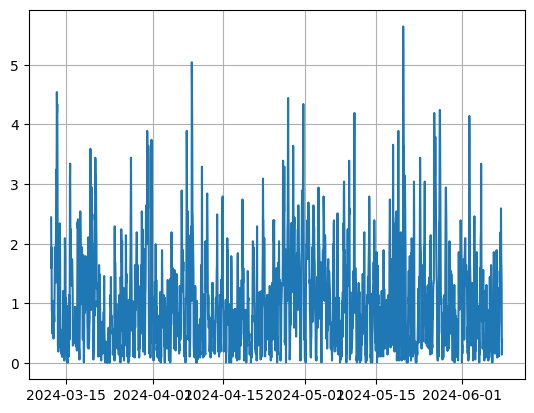

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = diff["date"]
s = diff["temperature_2m"]
#s = diff["apparent_temperature"]

fig, ax = plt.subplots()
ax.plot(t, s)

# ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#        title='About as simple as it gets, folks')
ax.grid()
plt.show()


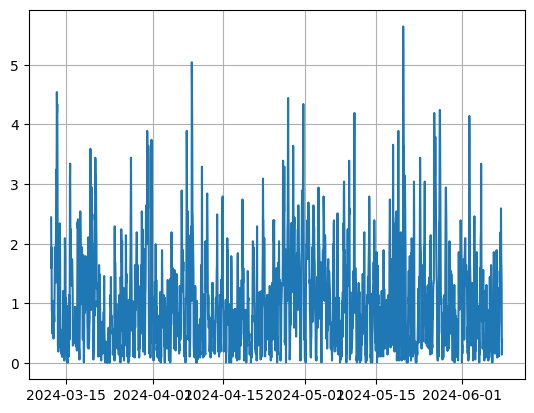

In [60]:
import matplotlib.pyplot as plt
import numpy as np


def plotTemperature(df, dateColumn = "date", tempColumn = "temperature_2m"):
    t = df[dateColumn]
    s = df[tempColumn]
    fig, ax = plt.subplots()
    ax.plot(t, s)
    ax.grid()
    plt.show()

plotTemperature(diff)

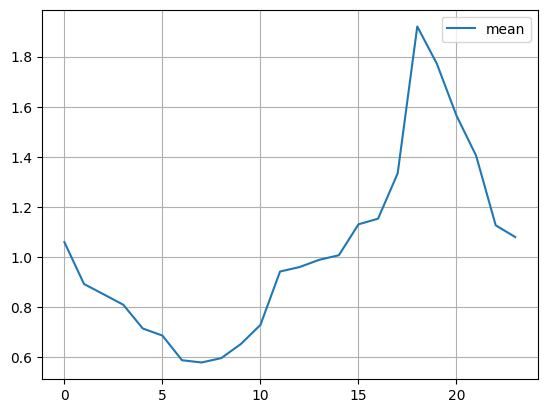

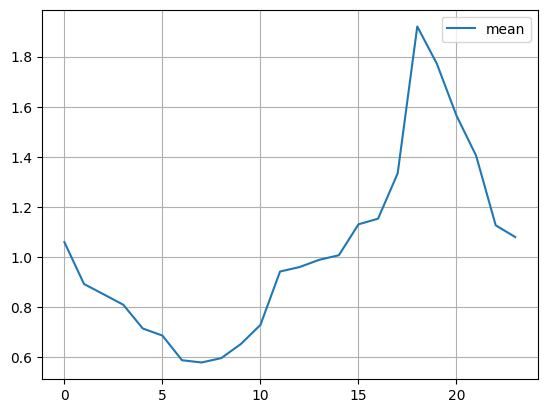

In [61]:
import matplotlib.pyplot as plt

def plotDifByHour(column = "temperature_2m"):
    mean_diff = diff.groupby(diff["date"].dt.hour)[[col for col in diff.columns if col != 'date']].mean().reset_index()
    fig, ax = plt.subplots()
    ax.plot(mean_diff["date"], mean_diff["temperature_2m"], label="mean")
    ax.grid()
    plt.legend()
    plt.show()

plotDifByHour()
plotDifByHour("apparent_temperature")

Group: 0
Group: 1
Group: 2
Group: 3
Group: 4
Group: 5
Group: 6
Group: 7
Group: 8
Group: 9
Group: 10
Group: 11
Group: 12
Group: 13
Group: 14
Group: 15
Group: 16
Group: 17
Group: 18
Group: 19
Group: 20
Group: 21
Group: 22
Group: 23


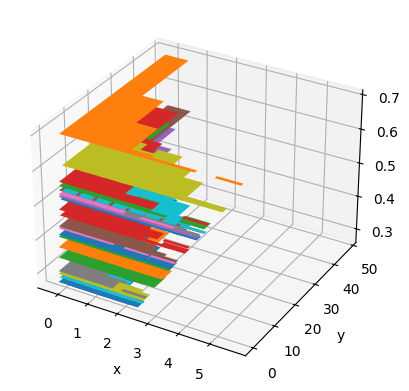

In [62]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

grouped_diff = diff.groupby(diff["date"].dt.hour)
for hour, data in grouped_diff:
    print("Group:", hour)
    n, bins, _ = plt.hist(data["temperature_2m"], bins=8)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

312
312


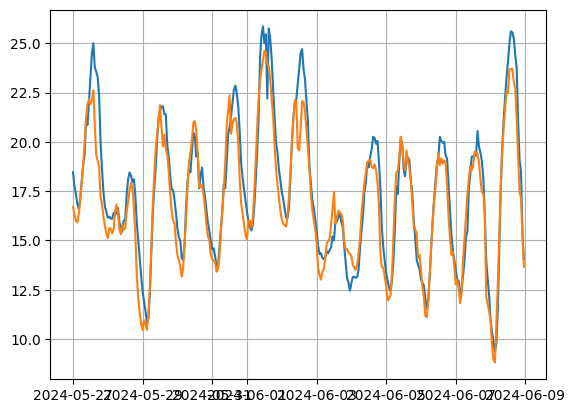

In [68]:
import matplotlib.pyplot as plt
import numpy as np

pastDays = 14
date_x_days_ago = datetime.now() - timedelta(days=pastDays)
formatted_date = date_x_days_ago.strftime('%Y-%m-%d')

fig, ax = plt.subplots()
ax.plot(forecast["date"], forecast["temperature_2m"])
ax.plot(archive["date"], archive["temperature_2m"])

# ax.plot(forecast["date"], forecast["precipitation"])
# ax.plot(archive["date"], archive["precipitation"])

# ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#        title='About as simple as it gets, folks')
ax.grid()
plt.show()


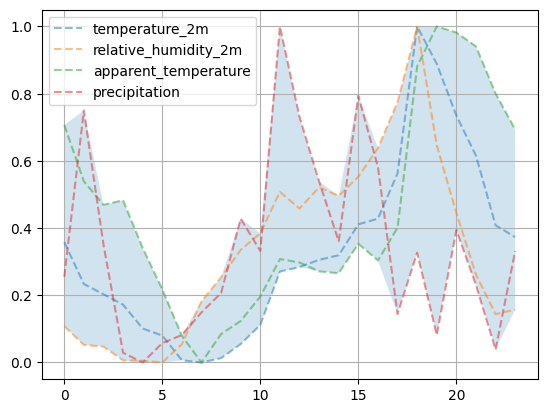

In [64]:
import numpy as np

def soft_max(col):
    return (col - np.min(col)) / (np.max(col) - np.min(col))

mean_diff = diff.groupby(diff["date"].dt.hour)[[col for col in diff.columns if col != "date"]].mean().apply(soft_max).reset_index()
fig, ax = plt.subplots()
    
for col in mean_diff.columns:
    if(col != "date"):
        ax.plot(mean_diff["date"], mean_diff[col], label=col, alpha = 0.5, linestyle='--')

ax.fill_between(mean_diff["date"], 
                mean_diff.drop(columns="date").min(axis=1),
                mean_diff.drop(columns="date").max(axis=1), alpha = 0.2)
    
ax.grid()
plt.legend()
plt.show()

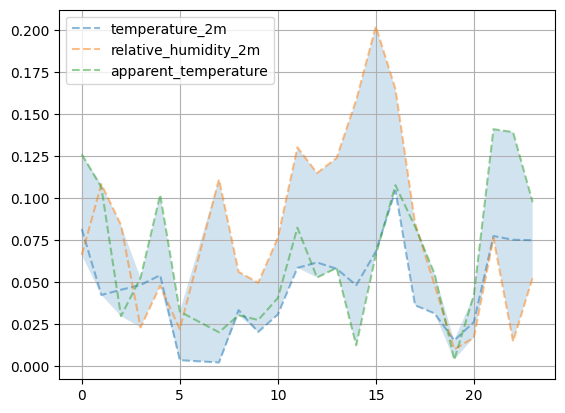

In [56]:
import numpy as np

mean_relative_diff = relative_diff.groupby(diff["date"].dt.hour)[[col for col in relative_diff.columns if col != "date"]].mean().drop(columns=["precipitation"]).reset_index()
fig, ax = plt.subplots()
    
for col in mean_relative_diff.columns:
    if(col != "date"):
        ax.plot(mean_relative_diff["date"], mean_relative_diff[col], label=col, alpha = 0.5, linestyle='--')

ax.fill_between(mean_relative_diff["date"], 
                mean_relative_diff.drop(columns="date").min(axis=1),
                mean_relative_diff.drop(columns="date").max(axis=1), alpha = 0.2)
    
ax.grid()
plt.legend()
plt.show()